## 1. Import Relevant Libraries


In [1]:
# import libraries
import pandas as pd
import numpy as np
import nltk
from pprint import pprint
nltk.download(['punkt', 'wordnet', 'stopwords'])
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
import spacy
import scattertext as st
import pickle
import seaborn as sn
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /Users/sabrina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sabrina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sabrina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !python -m spacy download en_core_web_lg

## 2. Data Understanding

In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('disaster_response', engine)

Y = df.iloc[:, 4:] # Classification label
categories = df.columns[4:]
df.shape

(26216, 40)

In [4]:
df.head()

id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   

                                            original   genre  related  \
0  Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                 Cyclone nan fini osinon li pa fini  direct        1   
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4  facade ouest d Haiti et le reste du pays aujou...  direct        1   

   request  offer  aid_related  medical_help  medical_products  ...  \
0        0      0            0             0                 0  ...   
1        0      0            1             0                 0  ...   
2        0      0            0             0                 0  ...   
3        1      0            1             0                 1  ...   
4        0      0            0             0                 0  ...   

   aid_centers  other_infrastructure  weather_related  floods  storm  fire  \
0            0                     0                0       0      0     0   
1            0                     0                1       0      1     0   
2            0                     0                0       0      0     0   
3            0                     0                0       0      0     0   
4            0                     0                0       0      0     0   

   earthquake  cold  other_weather  direct_report  
0           0     0              0              0  
1           0     0              0              0  
2           0     0              0              0  
3           0     0              0              0  
4           0     0              0              0  

[5 rows x 40 columns]

In [5]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [6]:
df['message'] = df['message'].str.replace("[^\w\s]", "").str.lower()
df['message'] = df['message'].apply(stemming)
X = df['message']  # Message Column

df['genre'].value_counts()

news      13054
direct    10766
social     2396
Name: genre, dtype: int64

In [7]:
df.describe()

id       related       request         offer   aid_related  \
count  26216.00000  26216.000000  26216.000000  26216.000000  26216.000000   
mean   15224.82133      0.759307      0.170659      0.004501      0.414251   
std     8826.88914      0.427512      0.376218      0.066940      0.492602   
min        2.00000      0.000000      0.000000      0.000000      0.000000   
25%     7446.75000      1.000000      0.000000      0.000000      0.000000   
50%    15662.50000      1.000000      0.000000      0.000000      0.000000   
75%    22924.25000      1.000000      0.000000      0.000000      1.000000   
max    30265.00000      1.000000      1.000000      1.000000      1.000000   

       medical_help  medical_products  search_and_rescue      security  \
count  26216.000000      26216.000000       26216.000000  26216.000000   
mean       0.079493          0.050084           0.027617      0.017966   
std        0.270513          0.218122           0.163875      0.132831   
min        0.000000          0.000000           0.000000      0.000000   
25%        0.000000          0.000000           0.000000      0.000000   
50%        0.000000          0.000000           0.000000      0.000000   
75%        0.000000          0.000000           0.000000      0.000000   
max        1.000000          1.000000           1.000000      1.000000   

           military  ...   aid_centers  other_infrastructure  weather_related  \
count  26216.000000  ...  26216.000000          26216.000000     26216.000000   
mean       0.032804  ...      0.011787              0.043904         0.278341   
std        0.178128  ...      0.107927              0.204887         0.448191   
min        0.000000  ...      0.000000              0.000000         0.000000   
25%        0.000000  ...      0.000000              0.000000         0.000000   
50%        0.000000  ...      0.000000              0.000000         0.000000   
75%        0.000000  ...      0.000000              0.000000         1.000000   
max        1.000000  ...      1.000000              1.000000         1.000000   

             floods         storm          fire    earthquake          cold  \
count  26216.000000  26216.000000  26216.000000  26216.000000  26216.000000   
mean       0.082202      0.093187      0.010757      0.093645      0.020217   
std        0.274677      0.290700      0.103158      0.291340      0.140743   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       other_weather  direct_report  
count   26216.000000   26216.000000  
mean        0.052487       0.193584  
std         0.223011       0.395114  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  

[8 rows x 37 columns]

## 3. Data Preparation

In [8]:
df_sum = pd.DataFrame({'categories': list(df[categories]),
                       'counts': list(df[categories].sum())})

df_sum

categories  counts
0                  related   19906
1                  request    4474
2                    offer     118
3              aid_related   10860
4             medical_help    2084
5         medical_products    1313
6        search_and_rescue     724
7                 security     471
8                 military     860
9              child_alone       0
10                   water    1672
11                    food    2923
12                 shelter    2314
13                clothing     405
14                   money     604
15          missing_people     298
16                refugees     875
17                   death    1194
18               other_aid    3446
19  infrastructure_related    1705
20               transport    1201
21               buildings    1333
22             electricity     532
23                   tools     159
24               hospitals     283
25                   shops     120
26             aid_centers     309
27    other_infrastructure    1151
28         weather_related    7297
29                  floods    2155
30                   storm    2443
31                    fire     282
32              earthquake    2455
33                    cold     530
34           other_weather    1376
35           direct_report    5075

## 4. Data Analysis and Visualization

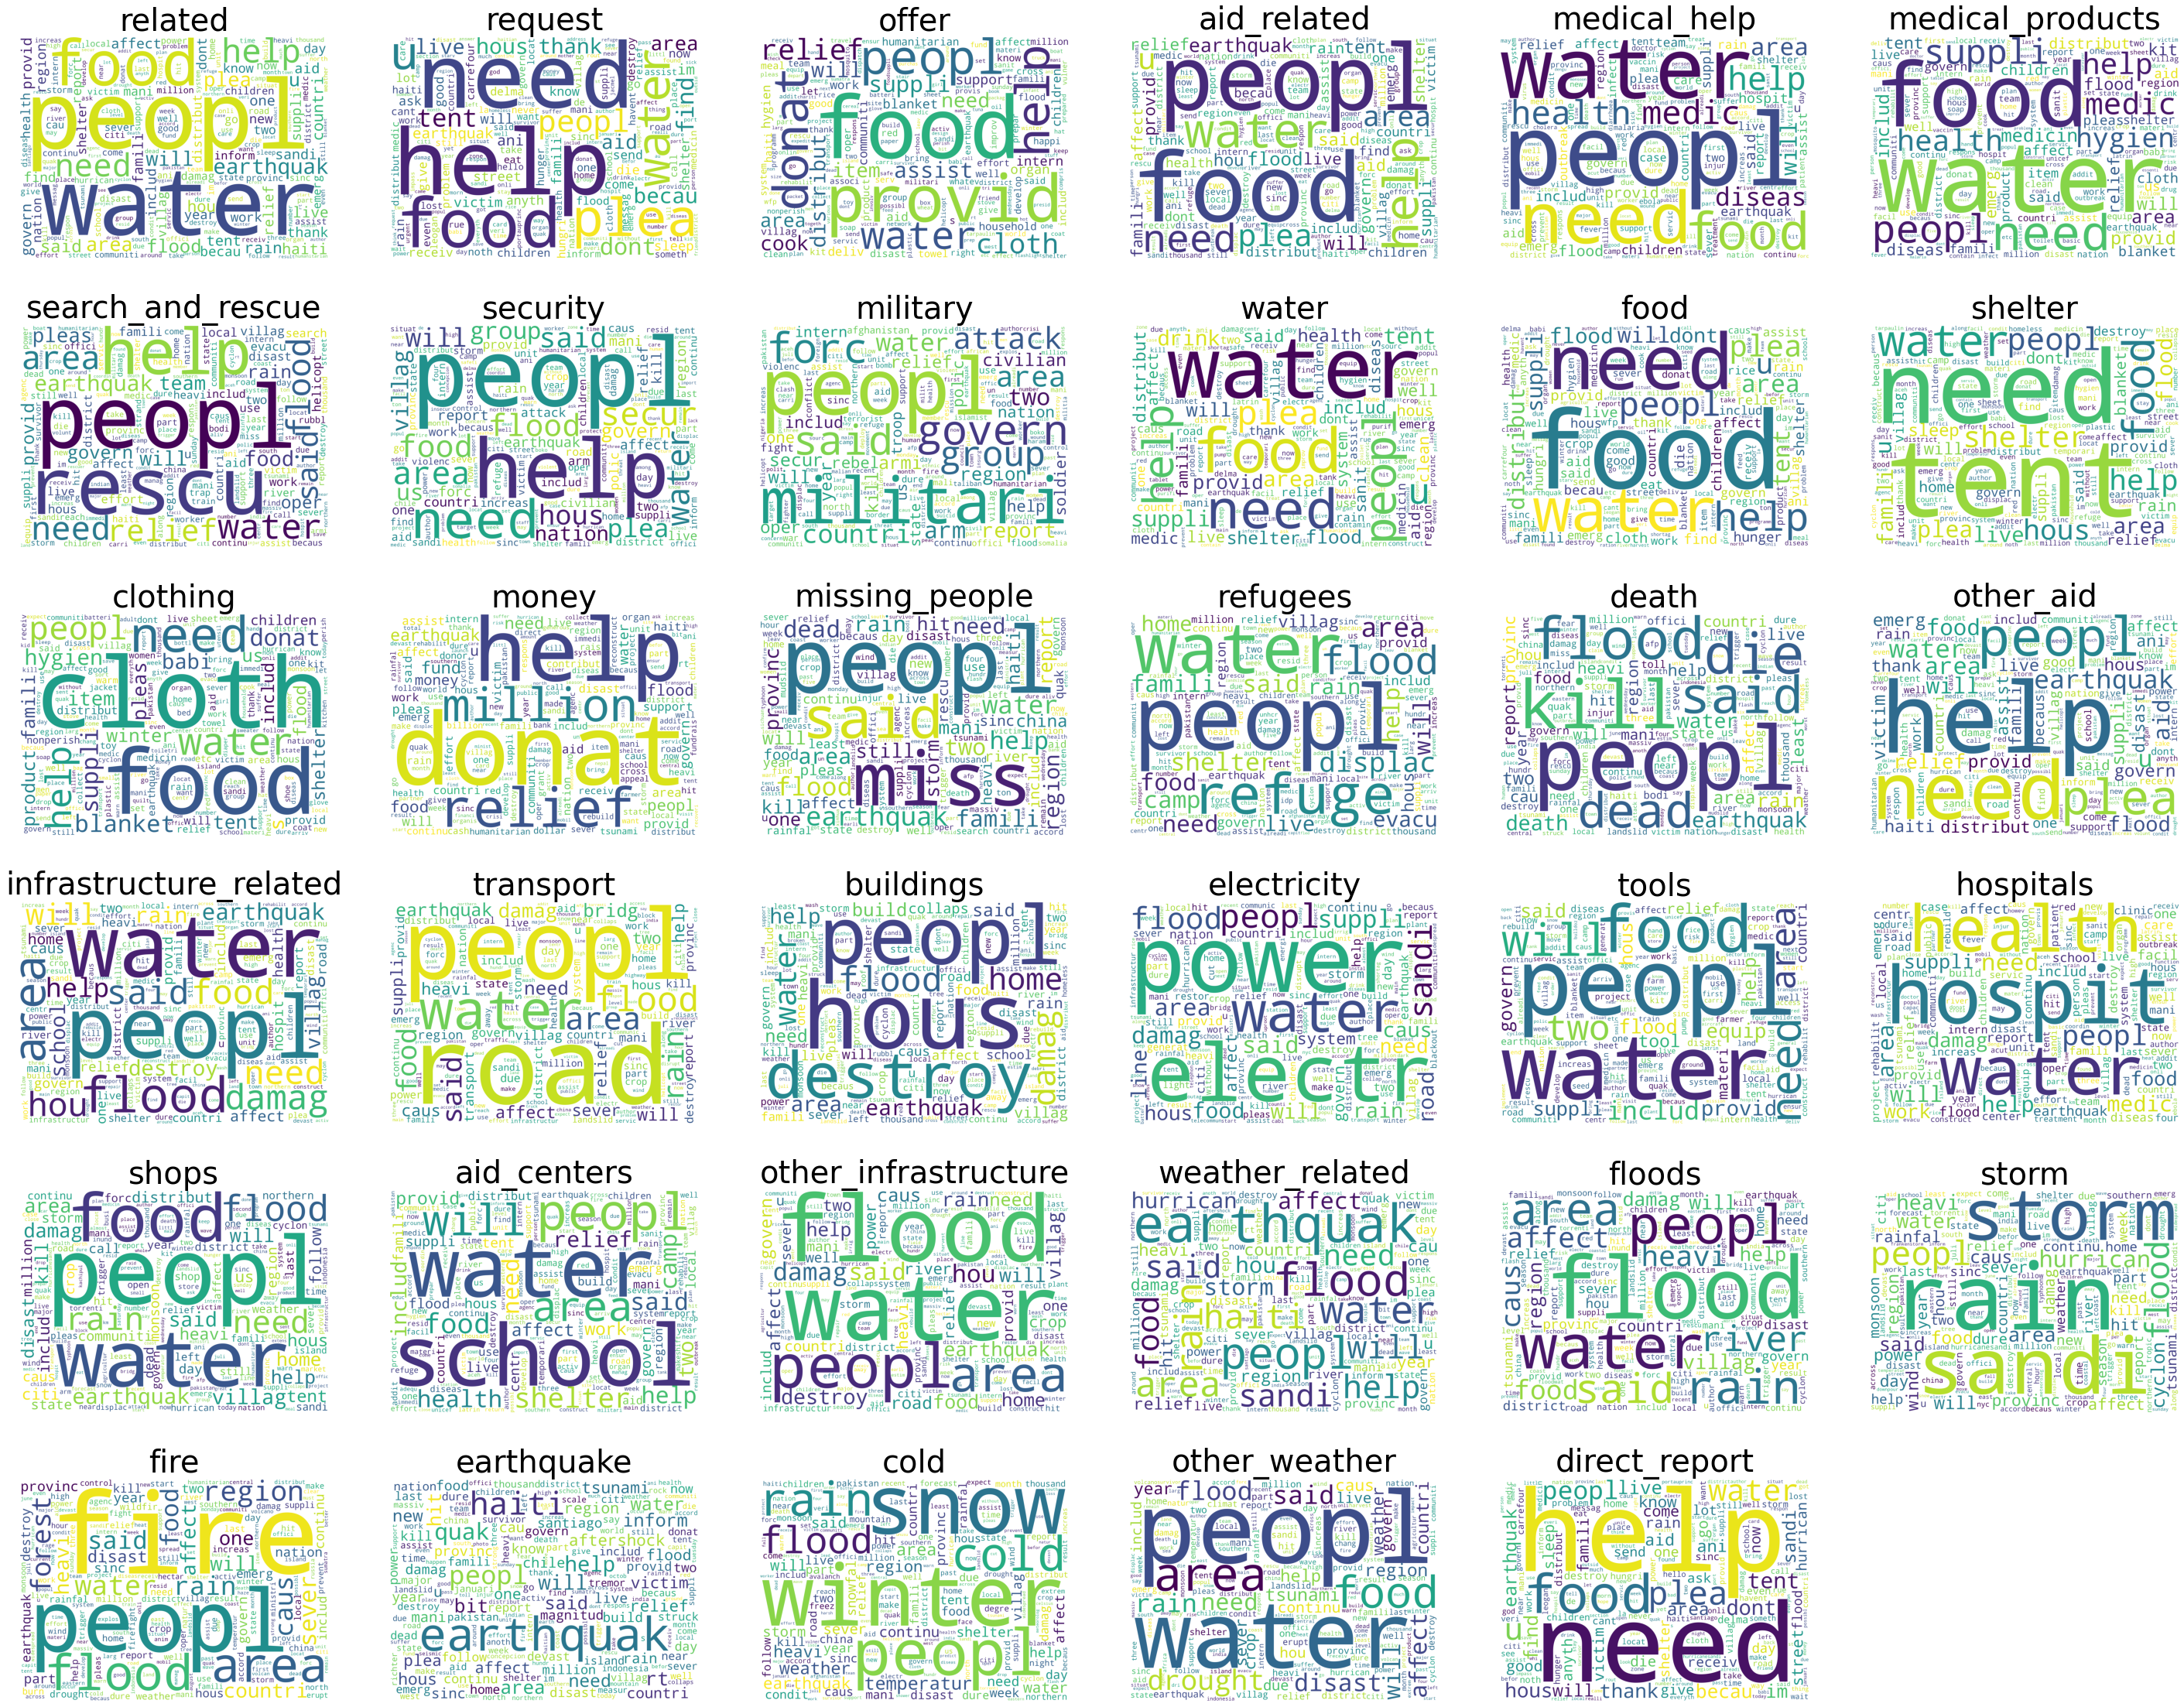

In [9]:
df = df.drop('child_alone', axis = 1)
categories = df.columns[4:]


from wordcloud import WordCloud,STOPWORDS


plt.figure(figsize=(50,40))
count = 1
for col in categories:
    subset = df[df[col]==1]
    text = subset.message.values
    cloud_toxic = WordCloud(
                              stopwords=STOPWORDS,
                              background_color='white',
                              collocations=False,
                              width=2500,
                              height=1800
                             ).generate(" ".join(text))

    plt.subplot(6, 6, count)
    plt.axis('off')
    plt.title(col,fontsize=40)
    plt.imshow(cloud_toxic)
    count += 1

plt.show()



In [10]:
list_sum = list((Y == 0).sum(axis=1))
df['help_needed'] = 1

for i in range(len(list_sum)):
    if list_sum[i] == 35:
        df.loc[i, 'help_needed'] = 0
df.shape 

(26216, 40)

In [11]:
df['help_needed'] = df['help_needed'].replace({1:'Yes', 0:'No'})

df['help_needed'].value_counts()

Yes    21095
No      5121
Name: help_needed, dtype: int64

In [12]:
# use the english model that you have
nlp = spacy.load('en_core_web_sm')


In [13]:
# Create a text file to add stop words
with open('stopwords.txt', 'r') as f:
    str_f = f.read()
    stopwords_file = set(str_f.split('\n'))
nlp.Defaults.stop_words |= stopwords_file

In [14]:
# Add more stop words
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
nlp.Defaults.stop_words |= stopWords

In [15]:
def term_freq(df):
    corpus = (st.CorpusFromPandas(df,
                                           category_col='help_needed', 
                                           text_col='message',
                                           nlp=nlp)
              .build()
              .remove_terms(nlp.Defaults.stop_words, ignore_absences=True)
              # ignore_absences: if the term does not appear, don't raise an error, just move on.
              )
    
    df = corpus.get_term_freq_df()
    df['Yes_Score'] = corpus.get_scaled_f_scores('Yes')
    df['No_Score'] = corpus.get_scaled_f_scores('No')

    df['Yes_Score'] = round(df['Yes_Score'], 2)
    df['No_Score'] = round(df['No_Score'], 2)
    
    df_yes = df.sort_values(by='Yes freq', 
                             ascending = False).reset_index()
    df_no = df.sort_values(by='No freq', 
                            ascending=False).reset_index()
    
    return df_yes, df_no, df, corpus

In [ ]:
df_yes, df_no, df_new, corpus = term_freq(df)

In [ ]:
# Sorted by help needed Frequency
df_yes.head(15)

In [ ]:
# Sorted by No help needed Frequency
df_no.head(15)

In [ ]:
# Label each excerpt with the name of category using the metadata parameter
corpus_dataframe = df
html = st.produce_scattertext_explorer(corpus,
                                                category='No',
                                                category_name='No',
                                                not_category_name='Yes',
                                                width_in_pixels=1000)

In [ ]:
html_file_name = "Disaster-Scattertext.html"
open(html_file_name, 'wb').write(html.encode('utf-8'))